In [1]:
# Cell 1 - imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
import statsmodels.api as sm
import shap

# load
path = "C:/Users/UserAdmin/Desktop/5126final/model/preprocessed_data.csv"   # adjust if needed
df = pd.read_csv(path)
print("rows, cols:", df.shape)
# quick peek
df[[c for c in df.columns if c.startswith('Q274')][:1]].head()


rows, cols: (2012, 287)


,Q274: How many children do you have
0,1.0
1,0.0
2,0.0
3,1.0
4,3.0


In [2]:
# Cell 2 - create age and target, filter
CURRENT_YEAR = 2025
# target column (as found)
target_col = 'Q274: How many children do you have'
birth_year_col = 'Q261: Year of birth'  # exists in dataset preview
country_col = 'Q266: Country of birth: Respondent'  # numeric ISO code

# convert to numeric and handle bad/missing
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
df[birth_year_col] = pd.to_numeric(df[birth_year_col], errors='coerce')
df[country_col] = pd.to_numeric(df[country_col], errors='coerce')

# compute age
df['age'] = CURRENT_YEAR - df[birth_year_col]

# childbearing filter: 20-49 (common bracket) — adjust if needed
df_childbearing = df[(df['age'] >= 20) & (df['age'] <= 49)].copy()
print("Childbearing Rows (i.e. Those Age 20-49):", df_childbearing.shape[0])

# Singapore subset (ISO numeric 702)
df_sg = df_childbearing[df_childbearing[country_col] == 702].copy()
print("Singapore rows (i.e. Singaporeans Age 20-49):", df_sg.shape[0])

# global (all countries in same age bracket)
df_global = df_childbearing.copy()


Childbearing Rows (i.e. Those Age 20-49): 875
Singapore rows (i.e. Singaporeans Age 20-49): 699


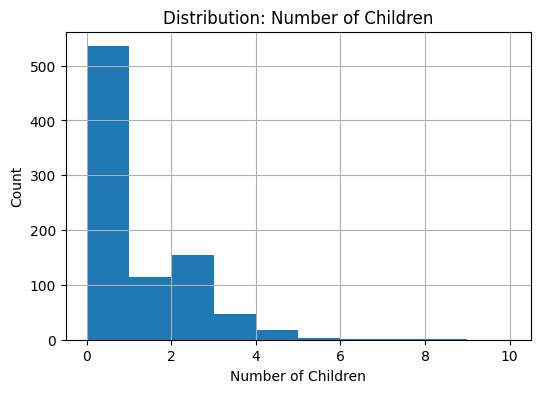

In [3]:
# Cell 3 - EDA: target distribution and missingness
import matplotlib.pyplot as plt

# target distribution
plt.figure(figsize=(6,4))
df_childbearing[target_col].dropna().hist(bins=range(0,11))
plt.title('Distribution: Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.show()

# missingness overview for top columns check for columnns with least missing values
#miss = df_childbearing.isnull().mean().sort_values()
#miss.head(30)


In [4]:
# Example: auto-select some candidate features by keyword rules (adjust manually for best features)
#value_keywords = ['Important', 'Duty', 'Worries', 'Satisfaction', 'Problem', 'attitude', 'value', 'worries', 'scale']
candidate_cols = [c for c in df.columns if any(k.lower() in c.lower() for k in ['important', 'duty', 'worries', 'satisfaction', 'problem', 'scale', 'chief wage', 'income', 'spend', 'household', 'employment', 'health'])]
# ensure target + controls present
controls = ['age', 'Q270: Number of people in household']
candidate_cols = list(dict.fromkeys(candidate_cols + controls))
len(candidate_cols), candidate_cols[:40]


(52,
 ['Q1: Important in life: Family',
  'Q2: Important in life: Friends',
  'Q3: Important in life: Leisure time',
  'Q4: Important in life: Politics',
  'Q5: Important in life: Work',
  'Q6: Important in life: Religion',
  'Q7: Important child qualities: good manners',
  'Q8: Important child qualities: independence',
  'Q9: Important child qualities: hard work',
  'Q10: Important child qualities: feeling of responsibility',
  'Q11: Important child qualities: imagination',
  'Q12: Important child qualities: tolerance and respect for other people',
  'Q13: Important child qualities: thrift saving money and things',
  'Q14: Important child qualities: determination perseverance',
  'Q15: Important child qualities: religious faith',
  'Q16: Important child qualities: unselfishness',
  'Q17: Important child qualities: obedience',
  'Q30: University is more important for a boy than for a girl',
  'Q35: Problem if women have more income than husband',
  'Q37: Duty towards society to have ch

In [5]:
# Cell 5A - Poisson using statsmodels (requires adding constant)
# Ensure required variables exist (features, X_sg_proc, y_sg). Fall back to sensible defaults.

# use candidate_cols (from earlier cell) if 'features' is not defined
if 'features' not in globals():
	features = candidate_cols  # candidate_cols defined in Cell 3

# Prepare X and y from the Singapore subset df_sg
X_sg = df_sg[features].copy()
y_sg = df_sg[target_col].copy()

# keep only rows with observed target
mask = y_sg.notna()
X_sg = X_sg.loc[mask]
y_sg = y_sg.loc[mask]

# simple preprocessing: impute numeric missings with column medians
X_sg_proc = X_sg.fillna(X_sg.median())

# add constant and fit Poisson GLM
X_sm = sm.add_constant(X_sg_proc)
poisson_model = sm.GLM(y_sg.values, X_sm, family=sm.families.Poisson()).fit()
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  699
Model:                            GLM   Df Residuals:                      646
Model Family:                 Poisson   Df Model:                           52
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -563.84
Date:                Wed, 05 Nov 2025   Deviance:                       543.40
Time:                        00:21:26   Pearson chi2:                     600.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5949
Covariance Type:            nonrobust                                         
                                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

In [6]:
#nb_model = sm.GLM(y_sg.values, X_sm, family=sm.families.NegativeBinomial()).fit()
#print(nb_model.summary())


In [7]:
# Cell 5B - RF regressor with cross-validation
rf = RandomForestRegressor(n_estimators=200, random_state=42)
scores = cross_val_score(rf, X_sg_proc, y_sg, cv=5, scoring='neg_mean_squared_error') #splitting comprised of 5 folds
print("CV RMSE:", np.sqrt(-scores).mean())
# train final
rf.fit(X_sg_proc, y_sg)


CV RMSE: 0.8533345995387803


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Cell 5C - classification bucket
# Use the already-prepared y_sg (filtered) and X_sg_proc (processed) to build a classification target
y_class = pd.cut(y_sg, bins=[-1,0,1,100], labels=['0','1','2+'])

# RandomForestClassifier is already imported in an earlier cell; do not re-import
clf = RandomForestClassifier(n_estimators=200, random_state=42)
X_proc = X_sg_proc
clf.fit(X_proc, y_class)

print("Train acc:", clf.score(X_proc, y_class))


Train acc: 1.0


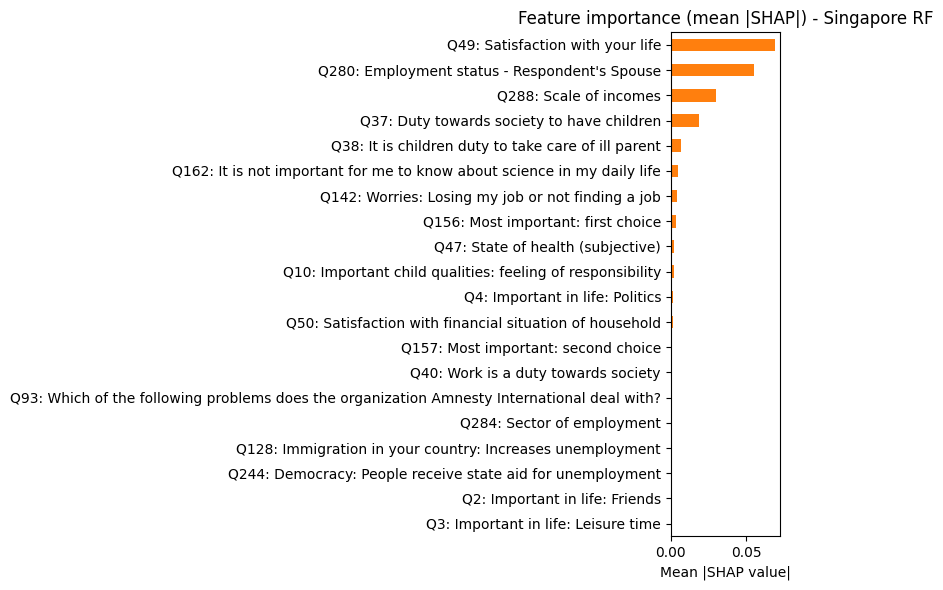

Top 10 features by mean |SHAP|:
Q49: Satisfaction with your life                                           0.068743
Q280: Employment status - Respondent's Spouse                              0.054830
Q288: Scale of incomes                                                     0.029862
Q37: Duty towards society to have children                                 0.018854
Q38: It is children duty to take care of ill parent                        0.007095
Q162: It is not important for me to know about science in my daily life    0.004844
Q142: Worries: Losing my job or not finding a job                          0.004294
Q156: Most important: first choice                                         0.003751
Q47: State of health (subjective)                                          0.002174
Q10: Important child qualities: feeling of responsibility                  0.002120
dtype: float64


In [9]:
# Cell 6 - SHAP: simplified ranked mean(|SHAP|) horizontal bar chart
# This cell preserves DataFrame column names, samples a small background for TreeExplainer,
# and plots mean absolute SHAP per feature as a horizontal bar chart (top-N).
# Ensure prerequisites: `features`, `X_sg`, `y_sg`, and `rf` should exist from earlier cells.

# ensure a preprocessor exists and is fitted (fit on X_sg if needed)
if 'preprocessor' not in globals():
    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
# try a quick transform to detect if fitted; otherwise fit on X_sg
try:
    _ = preprocessor.transform(X_sg.iloc[:1])
except Exception:
    preprocessor.fit(X_sg.fillna(X_sg.median()))

# build a DataFrame of preprocessed features so column names are preserved
if 'X_sg_proc_df' in globals():
    X_shap_df = X_sg_proc_df.copy()
else:
    X_shap_input = X_sg[features].copy()
    X_shap_input = X_shap_input.fillna(X_shap_input.median())
    X_shap_proc = preprocessor.transform(X_shap_input)
    X_shap_df = pd.DataFrame(X_shap_proc, columns=features, index=X_shap_input.index)

# Ensure the RF model has feature names info; if not, clone & (re)fit on DataFrame slice
from sklearn.base import clone
rf_for_shap = rf
need_refit = False
if not hasattr(rf_for_shap, 'feature_names_in_'):
    need_refit = True
else:
    try:
        if list(rf_for_shap.feature_names_in_) != list(features):
            need_refit = True
    except Exception:
        need_refit = True
if need_refit:
    rf_for_shap = clone(rf)
    rf_for_shap.fit(X_shap_df, y_sg.loc[X_shap_df.index])

# create a small background sample for the explainer (keeps things fast)
bg_n = min(200, len(X_shap_df))
bg = X_shap_df.sample(n=bg_n, random_state=0)

# compute SHAP values using TreeExplainer where possible; fallback to generic Explainer
try:
    expl = shap.TreeExplainer(rf_for_shap, data=bg)
    shap_vals = expl.shap_values(X_shap_df)
except Exception:
    expl = shap.Explainer(rf_for_shap.predict, bg)
    # shap.Explainer returns an object w/ .values for most models
    out = expl(X_shap_df)
    try:
        shap_vals = out.values
    except Exception:
        # final fallback: compute numeric array from object
        shap_vals = np.array(out)

# shap_vals might be a list (multiclass) or ndarray. Convert to absolute and average appropriately
import numpy as np
if isinstance(shap_vals, list):
    # for multiclass, average absolute values across classes
    arr = np.mean([np.abs(s) for s in shap_vals], axis=0)
else:
    arr = np.abs(shap_vals)
mean_abs = np.mean(arr, axis=0)
imp = pd.Series(mean_abs, index=features).sort_values(ascending=True)

# Plot top-N features as horizontal bar chart
topn = 20
imp_top = imp.tail(topn)
plt.figure(figsize=(8, max(4, 0.3 * topn)))
imp_top.plot.barh(color='C1')
plt.xlabel('Mean |SHAP value|')
plt.title('Feature importance (mean |SHAP|) - Singapore RF')
plt.tight_layout()
plt.show()

# Print the top 10 features for quick reference
print('Top 10 features by mean |SHAP|:')
print(imp.sort_values(ascending=False).head(10))


In [10]:
# Cell 7 - replicate modelling on global sample; compare feature importance
# Prepare global dataset same way:
global_df = df_global.dropna(subset=[target_col]).copy()
global_df = global_df[(global_df['age'] >= 20) & (global_df['age'] <= 49)]

# You may need to subset to rows with valid features
X_global = global_df[features].copy()
y_global = global_df[target_col]

# Ensure a preprocessor exists (fit if missing). Use a simple numeric pipeline:
# SimpleImputer (median) + StandardScaler
if 'preprocessor' not in globals():
	preprocessor = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='median')),
		('scaler', StandardScaler())
	])
	# Prefer to fit on already-prepared Singapore data if available, otherwise fit on X_global
	if 'X_sg_proc' in globals():
		preprocessor.fit(X_sg_proc)
	else:
		preprocessor.fit(X_global.fillna(X_global.median()))

# Transform global features (pipeline will impute missing values)
X_global_proc = preprocessor.transform(X_global)

# Train RF on global
rf_global = RandomForestRegressor(n_estimators=200, random_state=42)
rf_global.fit(X_global_proc, y_global)

# Compute permutation importances or SHAP for both and compare top 15
importances_sg = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False).head(15)
#importances_global = pd.Series(rf_global.feature_importances_, index=features).sort_values(ascending=False).head(15)
print("SG top features:\n", importances_sg)
#print("Global top features:\n", importances_global)


SG top features:
 Q270: Number of people in household                                                          0.286594
age                                                                                          0.221736
Q280: Employment status - Respondent's Spouse                                                0.028431
Q49: Satisfaction with your life                                                             0.027979
Q37: Duty towards society to have children                                                   0.027100
Q288: Scale of incomes                                                                       0.025347
Q35: Problem if women have more income than husband                                          0.022692
Q247: Democracy: The state makes people's incomes equal                                      0.021523
Q6: Important in life: Religion                                                              0.020754
Q252: Satisfaction with the political system performance        

In [11]:
# Cell 8 - interaction example
global_df['income_scale'] = global_df['Q288: Scale of incomes']  # rename as needed
# create an interaction term example: income_scale * 'Problem if women have more income than husband'
global_df['interaction_example'] = (global_df['Q288: Scale of incomes'].fillna(0) *
                                   global_df['Q35: Problem if women have more income than husband'].fillna(0))
# include interaction in model


In [12]:
'''# Cell 9 - streamlit prototype sketch (save as app.py)
import streamlit as st
import pickle
from pathlib import Path

st.title("Family Planning Insight Tool (Prototype)")
age = st.number_input("Age", min_value=18, max_value=60, value=30)
income_scale = st.selectbox("Income scale", [1,2,3,4,5])
q_duty = st.slider("Duty towards society to have children (low-high)", 0, 10, 5)

# Try to load persisted artifacts, but fall back to in-memory objects if pickles are not present
# (This avoids FileNotFoundError when running from a different working directory.)
def try_load_pickle_candidates(name, candidates):
    for p in candidates:
        try:
            if Path(p).exists():
                return pickle.load(open(p, "rb"))
        except Exception:
            continue
    return None

# prepare candidate paths (prefer out_dir if available)
model_candidates = []
preproc_candidates = []
if 'out_dir' in globals():
    model_candidates.append(Path(out_dir) / "rf_sg_model.pkl")
    preproc_candidates.append(Path(out_dir) / "preprocessor.pkl")
# also try current working dir
model_candidates += [Path("rf_sg_model.pkl")]
preproc_candidates += [Path("preprocessor.pkl")]

# load model
model = try_load_pickle_candidates("model", model_candidates)
if model is None:
    # fallback to in-memory trained objects if available
    if 'model_to_save' in globals():
        model = model_to_save
    elif 'rf' in globals():
        model = rf
    else:
        st.error("No model found: tried rf_sg_model.pkl and in-memory 'rf'. Please run training cells or place rf_sg_model.pkl in the notebook folder.")
        st.stop()

# load preprocessor
preprocessor = try_load_pickle_candidates("preprocessor", preproc_candidates)
if preprocessor is None:
    if 'preprocessor' in globals():
        preprocessor = globals()['preprocessor']
    else:
        st.warning("No preprocessor found; using identity (no preprocessing). Predictions may fail if model expects preprocessed input.")
        preprocessor = None

# pick a SHAP explainer object (prefer existing global expl / explainer)
if 'expl' in globals():
    explainer_obj = globals()['expl']
elif 'explainer' in globals():
    explainer_obj = globals()['explainer']
else:
    # try to construct a TreeExplainer if shap and a background exist
    try:
        import shap
        if 'X_shap_df' in globals():
            bg = X_shap_df.sample(n=min(200, len(X_shap_df)), random_state=0)
            explainer_obj = shap.TreeExplainer(model, data=bg)
        else:
            explainer_obj = None
    except Exception:
        explainer_obj = None

if st.button("Get insight"):
    # build input row and ensure required columns exist in features
    x = pd.DataFrame([{ 'age': age, 'Q288: Scale of incomes': income_scale, 'Q37: Duty towards society to have children': q_duty }])
    missing = [f for f in features if f not in x.columns]
    # add missing feature columns with NA so transformer can handle imputation
    for m in missing:
        x[m] = np.nan

    # apply preprocessor if present
    if preprocessor is not None:
        try:
            Xp_proc = preprocessor.transform(x[features])
            # keep a DataFrame version for SHAP (preserve column names)
            try:
                Xp_df = pd.DataFrame(Xp_proc, columns=features, index=x.index)
            except Exception:
                Xp_df = None
        except Exception as e:
            st.error(f"Preprocessor transform failed: {e}")
            st.stop()
    else:
        # no preprocessing available: use raw features (will likely fail if model expects preprocessed input)
        Xp_proc = x[features].values
        Xp_df = x[features].copy()

    # predict
    try:
        pred_children = float(model.predict(Xp_proc)[0])
        st.write(f"Modelled expected number of children: {pred_children:.2f}")
    except Exception as e:
        st.error(f"Prediction failed: {e}")
        st.stop()

    # show SHAP explanation if explainer exists
    if explainer_obj is not None and Xp_df is not None:
        try:
            shap_vals = explainer_obj(Xp_df)
            # shap.plots.force returns a matplotlib figure/plot for some explainers
            import shap
            fig = shap.plots.force(shap_vals, matplotlib=True)
            st.pyplot(fig)
        except Exception as e:
            st.warning(f"Could not render SHAP force plot: {e}")
    else:
        st.info("SHAP explainer not available in this session.")

#export streamlit_app.py
#!/usr/bin/env python3
import streamlit as st
import pickle
from pathlib import Path
st.title("Family Planning Insight Tool (Prototype)")
age = st.number_input("Age", min_value=18, max_value=60, value=30)
income_scale = st.selectbox("Income scale", [1,2,3,4,5])
q_duty = st.slider("Duty towards society to have children (low-high)", 0, 10, 5)
# Try to load persisted artifacts, but fall back to in-memory objects if pickles are not present
# (This avoids FileNotFoundError when running from a different working directory.)
def try_load_pickle_candidates(name, candidates):
    for p in candidates:
        try:
            if Path(p).exists():
                return pickle.load(open(p, "rb"))
        except Exception:
            continue
    return None
# prepare candidate paths (prefer out_dir if available)
model_candidates = []
preproc_candidates = []
if 'out_dir' in globals():
    model_candidates.append(Path(out_dir) / "rf_sg_model.pkl")
    preproc_candidates.append(Path(out_dir) / "preprocessor.pkl")
# also try current working dir
model_candidates += [Path("rf_sg_model.pkl")]
preproc_candidates += [Path("preprocessor.pkl")]
# load model
model = try_load_pickle_candidates("model", model_candidates)
if model is None:
    # fallback to in-memory trained objects if available
    if 'model_to_save' in globals():
        model = model_to_save
    elif 'rf' in globals():
        model = rf
    else:
        st.error("No model found: tried rf_sg_model.pkl and in-memory 'rf'. Please run training cells or place rf_sg_model.pkl in the notebook folder.")
        st.stop()
# load preprocessor
preprocessor = try_load_pickle_candidates("preprocessor", preproc_candidates)
if preprocessor is None:
    if 'preprocessor' in globals():
        preprocessor = globals()['preprocessor']
    else:
        st.warning("No preprocessor found; using identity (no preprocessing). Predictions may fail if model expects preprocessed input.")
        preprocessor = None
# pick a SHAP explainer object (prefer existing global expl / explainer)
if 'expl' in globals():
    explainer_obj = globals()['expl']
elif 'explainer' in globals():
    explainer_obj = globals()['explainer']
else:
    # try to construct a TreeExplainer if shap and a background exist
    try:
        import shap
        if 'X_shap_df' in globals():
            bg = X_shap_df.sample(n=min(200, len(X_shap_df)), random_state=0)
            explainer_obj = shap.TreeExplainer(model, data=bg)
        else:
            explainer_obj = None
    except Exception:
        explainer_obj = None
if st.button("Get insight"):
    # build input row and ensure required columns exist in features
    x = pd.DataFrame([{ 'age': age, 'Q288: Scale of incomes': income_scale, 'Q37: Duty towards society to have children': q_duty }])
    missing = [f for f in features if f not in x.columns]
    # add missing feature columns with NA so transformer can handle imputation
    for m in missing:
        x[m] = np.nan
    # apply preprocessor if present
    if preprocessor is not None:
        try:
            Xp_proc = preprocessor.transform(x[features])
            # keep a DataFrame version for SHAP (preserve column names)
            try:
                Xp_df = pd.DataFrame(Xp_proc, columns=features, index=x.index)
            except Exception:
                Xp_df = None
        except Exception as e:
            st.error(f"Preprocessor transform failed: {e}")
            st.stop()
    else:
        # no preprocessing available: use raw features (will likely fail if model expects preprocessed input)
        Xp_proc = x[features].values
        Xp_df = x[features].copy()
    # predict
    try:
        pred_children = float(model.predict(Xp_proc)[0])
        st.write(f"Modelled expected number of children: {pred_children:.2f}")
    except Exception as e:
        st.error(f"Prediction failed: {e}")
        st.stop()
    # show SHAP explanation if explainer exists
    if explainer_obj is not None and Xp_df is not None:
        try:
            shap_vals = explainer_obj(Xp_df)
            # shap.plots.force returns a matplotlib figure/plot for some explainers
            import shap
            fig = shap.plots.force(shap_vals, matplotlib=True)
            st.pyplot(fig)
        except Exception as e:
            st.warning(f"Could not render SHAP force plot: {e}")
    else:
        st.info("SHAP explainer not available in this session.")
#export app.py
'''

'# Cell 9 - streamlit prototype sketch (save as app.py)\nimport streamlit as st\nimport pickle\nfrom pathlib import Path\n\nst.title("Family Planning Insight Tool (Prototype)")\nage = st.number_input("Age", min_value=18, max_value=60, value=30)\nincome_scale = st.selectbox("Income scale", [1,2,3,4,5])\nq_duty = st.slider("Duty towards society to have children (low-high)", 0, 10, 5)\n\n# Try to load persisted artifacts, but fall back to in-memory objects if pickles are not present\n# (This avoids FileNotFoundError when running from a different working directory.)\ndef try_load_pickle_candidates(name, candidates):\n    for p in candidates:\n        try:\n            if Path(p).exists():\n                return pickle.load(open(p, "rb"))\n        except Exception:\n            continue\n    return None\n\n# prepare candidate paths (prefer out_dir if available)\nmodel_candidates = []\npreproc_candidates = []\nif \'out_dir\' in globals():\n    model_candidates.append(Path(out_dir) / "rf_sg_

In [ ]:
# Export Streamlit app to app.py
from pathlib import Path

# Save to the current working directory (i.e., alongside this notebook)
APP_PATH = Path.cwd() / "app.py"
APP_CODE = r'''import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import streamlit as st

# ---------- Setup ----------
st.set_page_config(page_title="Family Planning Insight Tool", page_icon="👶", layout="centered")
st.title("Family Planning Insight Tool")

APP_DIR = Path(__file__).resolve().parent
MODEL_PATH = APP_DIR / "rf_sg_model.pkl"
PREPROC_PATH = APP_DIR / "preprocessor.pkl"

@st.cache_resource(show_spinner=False)
def load_pickle(p: Path):
    try:
        with open(p, "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None
    except Exception as e:
        st.warning(f"Couldn't load {p.name}: {e}")
        return None

model = load_pickle(MODEL_PATH)
preprocessor = load_pickle(PREPROC_PATH)

if model is not None:
    st.success(f"Model loaded: {MODEL_PATH.name}")
else:
    st.info("Model file not found. Running in demo mode (mock prediction). Place rf_sg_model.pkl here to enable real predictions.")

if preprocessor is not None:
    st.success(f"Preprocessor loaded: {PREPROC_PATH.name}")
else:
    st.info("Preprocessor file not found. If your model expects preprocessing, place preprocessor.pkl here.")

# Attempt to discover training feature order from artifacts
feature_names = None
for obj in (preprocessor, model):
    if obj is None:
        continue
    feature_names = getattr(obj, "feature_names_in_", None)
    if feature_names is not None:
        feature_names = list(feature_names)
        break

# Try to find a 'satisfaction' column name from training features
satisfaction_key = None
if feature_names:
    for _name in feature_names:
        if "satisfaction" in str(_name).lower():
            satisfaction_key = _name
            break
if satisfaction_key is None:
    satisfaction_key = "satisfaction_in_life"

# ---------- UI ----------
st.subheader("Your inputs")
col1, col2 = st.columns(2)
with col1:
    age = st.number_input("Age", min_value=18, max_value=70, value=30, step=1)
    income_scale = st.selectbox("Income scale (1=lowest, 5=highest)", [1, 2, 3, 4, 5], index=2)
with col2:
    q_duty = st.slider("Duty towards society to have children", min_value=0, max_value=10, value=5, step=1)
    life_sat = st.slider("Satisfaction in life", min_value=0, max_value=10, value=6, step=1)

# Always reverse-code duty and satisfaction for the model (survey was reverse-coded)
q_duty_model = 10 - q_duty
life_sat_model = 10 - life_sat

# Build a single-row DataFrame expected by the model
# These names match the notebook features used in examples
input_row = {
    "age": age,
    "Q288: Scale of incomes": income_scale,
    "Q37: Duty towards society to have children": q_duty_model,
}
# Add satisfaction using best-matching training column name (or fallback key)
input_row[satisfaction_key] = life_sat_model

X_in = pd.DataFrame([input_row])

# If we know training feature order, align to it
if feature_names is not None:
    # Reindex to expected columns; fill any missing with 0
    X_aligned = X_in.reindex(columns=feature_names, fill_value=0)
else:
    X_aligned = X_in.copy()

# ---------- Predict ----------
predict_clicked = st.button("Predict expected number of children")

if predict_clicked:
    try:
        Xp = X_aligned
        if preprocessor is not None:
            # Use preprocessor only if available; assumes it's already fitted
            Xp = preprocessor.transform(Xp)

        if model is not None:
            # Real model prediction
            y_hat = model.predict(Xp)
            pred = float(np.squeeze(y_hat))
            pred = max(0.0, pred)  # clamp to non-negative
            st.metric("Predicted expected number of children", f"{pred:.2f}")
        else:
            # Demo fallback: a simple heuristic so the UI always works
            demo = 0.6 + 0.10 * (income_scale - 3) + 0.25 * (q_duty / 10.0) + 0.015 * (age - 30) + 0.05 * (life_sat / 10.0)
            demo = max(0.0, float(demo))
            st.metric("Predicted expected number of children (demo)", f"{demo:.2f}")
            st.info("This is a mock prediction. Add rf_sg_model.pkl to enable real predictions.")

    except Exception as e:
        st.error("Prediction failed. See details below.")
        with st.expander("Error details"):
            st.exception(e)

with st.expander("About & How to enable real predictions"):
    st.write(
        """
        This app loads optional artifacts from the same folder:
        - rf_sg_model.pkl — your trained model (e.g., RandomForestRegressor)
        - preprocessor.pkl — your fitted preprocessor (e.g., SimpleImputer or Imputer+Scaler Pipeline)

        Steps:
        1) Train in the notebook and run the save-artifacts cell. It writes both files here: app directory.
        2) Rerun this app. If artifacts are present and compatible, predictions will use your model.

        If your model expects more features, the app will align columns by name when possible. Missing features are filled with 0.
        """
    )

with st.expander("Debug info"):
    st.json({
        "app_dir": str(APP_DIR),
        "model_exists": MODEL_PATH.exists(),
        "preprocessor_exists": PREPROC_PATH.exists(),
        "feature_names_known": feature_names is not None,
        "feature_names_sample": feature_names[:5] if feature_names else None,
        "satisfaction_key": satisfaction_key,
        "q_duty_model_value": q_duty_model,
        "life_sat_model_value": life_sat_model,
        "input_columns": list(X_in.columns),
        "aligned_columns": list(X_aligned.columns),
    })
'''

APP_PATH.parent.mkdir(parents=True, exist_ok=True)
APP_PATH.write_text(APP_CODE, encoding="utf-8")
print({"exported": True, "path": str(APP_PATH), "bytes": APP_PATH.stat().st_size})

{'exported': True, 'path': 'c:\\Users\\UserAdmin\\Desktop\\5126final\\model\\app.py', 'bytes': 5980}


In [ ]:
# Save current RF model and a median-imputer as artifacts for Streamlit
from pathlib import Path
import pickle
from sklearn.impute import SimpleImputer

assert 'rf' in globals(), "RandomForest model 'rf' not found. Run the RF training cell first."
assert 'X_sg' in globals(), "Training features 'X_sg' not found. Run earlier data prep cells first."

# Fit an imputer to mimic the X_sg.fillna(median()) preprocessing used during training
imputer = SimpleImputer(strategy='median')
imputer.fit(X_sg)

# Save to the current working directory (same folder as the notebook)
out_dir = Path.cwd()
out_dir.mkdir(parents=True, exist_ok=True)

with open(out_dir / "rf_sg_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open(out_dir / "preprocessor.pkl", "wb") as f:
    pickle.dump(imputer, f)

print({"saved": True, "paths": [str(out_dir / "rf_sg_model.pkl"), str(out_dir / "preprocessor.pkl")]})

{'saved': True, 'paths': ['c:\\Users\\UserAdmin\\Desktop\\5126final\\model\\rf_sg_model.pkl', 'c:\\Users\\UserAdmin\\Desktop\\5126final\\model\\preprocessor.pkl']}
